In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
import math 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
def angle_btw_hits(arr1,arr2):
    theta1 = arr1[2]
    theta2 = arr2[2]
    phi1 = arr1[3]
    phi2 = arr2[3]
    opang = math.acos(math.sin(theta1)*math.sin(theta2)*math.cos(phi1-phi2)+math.cos(theta1)*math.cos(theta2))
    return opang

In [3]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [4]:
def run_r3b_clustering(data,clustersize):
    print(data.shape)
    array_unique_events = np.unique(my_data[:,0])
    print(array_unique_events)
    all_pred = []
    for i in range(0,(len(array_unique_events)-3),3):
        print("these are the events...")
        print(array_unique_events[i],array_unique_events[i+1],array_unique_events[i+2])
        evt = data[data[:,0] == array_unique_events[i]]
        evt = np.vstack((evt,data[data[:,0] == array_unique_events[i+1]]))
        evt = np.vstack((evt,data[data[:,0] == array_unique_events[i+2]]))
        nr_hits = evt.shape[0]
        hitnr = np.array([x for x in range(evt.shape[0])])
        hitnr = np.transpose(hitnr)
        hitnr = hitnr.reshape(-1, 1)
        evt = np.hstack((evt,hitnr))
        # sort along the energy
        evt = evt[evt[:, 1].argsort()[::-1]]
        #now check opening angle between the hits
        cluster_list = []
        while(evt.shape[0]):
            v_temp = []
            l = []
            for i in range(evt.shape[0]):
                if (i == 0):
                    l.append(evt[0,5].astype(int))
                else:
                    #calculate angle
                    angle = angle_btw_hits(evt[0,:],evt[i,:])
                    if (angle < clustersize):
                        l.append(evt[i,5].astype(int))
                    else:
                        v_temp.append(evt[i,:])
            l.sort()
            cluster_list.append(l)
            evt = np.array(v_temp)
        #compress list of clusters, they need at least two entries to be a cluster, otherwise the single hit is treated as cluster
        compr_cluster_list = []
        for i in range(len(cluster_list)):
            if len(cluster_list[i]) > 1:
                compr_cluster_list.append(cluster_list[i])
            else:
                continue
        final_pair_list = []
        for i in range(len(compr_cluster_list)):
            pair_indices = list(combinations(compr_cluster_list[i],2))
            #print(pair_indices)
            final_pair_list.append(pair_indices)
        reco_indices = flatten(final_pair_list)
        print("reco indices",reco_indices)
        # compare all combinations with all predicted combinations
        all_combinations = list(combinations(range(nr_hits), 2))
        print("all combinatins:",all_combinations)
        ## predictions
        pred_list = []
        for i in range(len(all_combinations)):
            pred_value = 0
            for j in range(len(reco_indices)):
                if (all_combinations[i] == reco_indices[j]):
                    #print(type(reco_indices[j]))
                    pred_value = 1
            pred_list.append(pred_value)
            all_pred.append(pred_value)
        print("ped_list",pred_list)
    print(len(all_pred))
    return all_pred
        




        

In [5]:
my_data = genfromtxt('raw_data_test.txt', delimiter=',')
#my_data = genfromtxt('/home/tobias/super_tmp/data_stream_2121.txt', delimiter=',')
#my_data[:,4] = my_data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius
my_data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius
# ### structure of mydata : eventnr, energy, theta, phi, hit-time
my_data = my_data*[1.,1.,3.14159/180,3.14159/180,1.]
out_cluster_r3b = run_r3b_clustering(my_data,0.25)

(17641, 5)
[0.0000e+00 2.0000e+00 3.0000e+00 ... 2.4187e+04 2.4193e+04 2.4195e+04]
these are the events...
0.0 2.0 3.0
reco indices [(1, 2), (1, 3), (2, 3), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
all combinatins: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
ped_list [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
these are the events...
4.0 5.0 6.0
reco indices [(0, 1), (5, 6), (5, 7), (6, 7), (2, 3), (2, 4), (3, 4)]
all combinatins: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
ped_list [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
these are the eve

## now method to plot data:

8859
0.488235
2.132567
2.02628
2.10281
2.080955
2.128761
2.051641
2.066401
2.09309
1.128016
1.386997
2.209619
1.759041
2.1173599999999997
1.628492
2.12472
2.092584
2.066007
2.118491
0.616926
2.076128
2.022886
2.116435
0.986253
2.173569
2.029792
0.756178
2.093987
2.10677
2.102718
0.262859
2.0702160000000003
2.063307
2.115305
2.16783
2.09523
0.863598
1.992584
1.937567
2.06427
2.141948
2.12838
2.131131
2.122036
2.13592
2.1872
2.168095
2.12424
1.70018
2.101277
2.10023
2.1655670000000002
2.083081
2.17151
2.073052
2.011901
2.078346
2.177949
2.061031
2.154091
2.192101
2.119615
0.654413
2.1448679999999998
2.15067
0.510213
2.104025
2.12104
2.199238
2.164813
1.767078
2.109552
2.21282
2.0886
2.131456
2.14323
2.1423579999999998
1.1628530000000001
2.04932
2.16009
1.5529469999999999
2.05754
2.1337729999999997
2.16149
2.103202
2.136711
0.865619
2.06022
2.16085
2.139949
2.09275
2.067468
2.152387
2.12221
2.088613
2.17268
2.05014
2.086061
2.10358
2.173153
0.813013
1.12525
2.15822
2.189067
2.084729
2.143

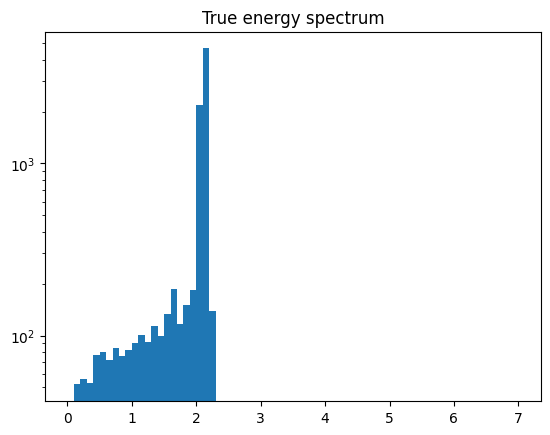

In [6]:
data = my_data
energy_spec = []
unique_ind = np.unique(data[:,0])
print(unique_ind.shape[0])
for i in unique_ind:
    ene = np.sum(data[data[:,0] == i,1])
    print (ene)
    energy_spec.append(ene)

plt.hist(energy_spec,bins=70,range=(0,7))
plt.title("True energy spectrum")
plt.yscale('log')


[[0.00000000e+00 4.88235000e-01 1.10095800e+00 6.23068054e+00
  1.00000000e+00]
 [2.00000000e+00 1.29252000e+00 6.91807789e-01 1.12018104e+00
  1.00000000e+00]
 [2.00000000e+00 4.22443000e-01 7.36273504e-01 1.12050218e+00
  1.00000000e+00]
 ...
 [2.41930000e+04 2.97576000e-01 1.01517863e+00 3.19429890e+00
  1.00000000e+00]
 [2.41930000e+04 1.22752000e-01 1.05914693e+00 3.09010283e+00
  1.00000000e+00]
 [2.41950000e+04 1.47413000e+00 1.33081767e+00 4.77076621e+00
  1.00000000e+00]]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 

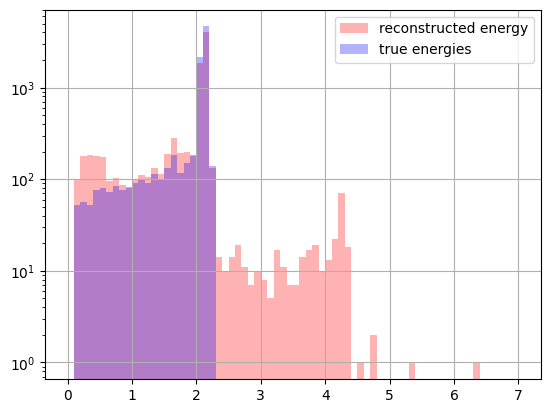

In [7]:
import networkx as nx
print(data)
ene_list = []
idx = 0
print(out_cluster_r3b)
array_unique_events = np.unique(data[:,0])

#for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
for i in range(0,(len(array_unique_events)-3),3):
    mask = ((data[:,0] == array_unique_events[i]) | (data[:,0] == array_unique_events[i+1]) | (data[:,0] == array_unique_events[i+2]))
    evt = data[mask]
    #print(evt)
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    ##pair indices which belong together...
    pred_comb = []
    for m in range(evt.shape[0]):
        pred_comb.append((m,m))
    for j in range (len(pair_indices)):
        if out_cluster_r3b[idx+j] > 0.75:
            pred_comb.append(pair_indices[j])
    print("prelcluster or somewhat:\t",pred_comb)
    G = nx.Graph()
    G.add_edges_from(pred_comb)
    connected_components = list(nx.connected_components(G))
    print("Connected components:", connected_components)
    #print(type(connected_components))
    for k in range(len(connected_components)):
        #print("this is type of k:")
        columns_to_sum = evt[list(connected_components[k]),1]
        ene = np.sum(columns_to_sum)
        ene_list.append(ene)
        #print(ene)
        #print(type(connected_components[k]))
    idx += len(pair_indices)
single_hit_energies = []
for i in range(data.shape[0]):
    single_hit_energies.append(data[i,1])

print(ene_list)
#plt.hist(single_hit_energies,bins=70,range=(0,7),label="single hit energy",color="green",alpha=0.5)    
plt.hist(ene_list,bins=70,range=(0,7),label="reconstructed energy",color="red",alpha=0.3)
plt.grid()
plt.hist(energy_spec,bins=70,range=(0,7),label="true energies",color="blue",alpha=0.3)
plt.legend()
plt.yscale('log')


### ideas for implementation
large_list = []
while (data.shape[0]):

    v_temp = empty
    l = []
    for i in range(data.shape[0]):
        if (i == 0):
            l.append(data[0,6])
        else:
            #calculate angle
            if (angle < clustersize):
                l.append(data[i,6])
            else:
                v_temp.append(data[i,:])
    large_list.append(l)
    data = v_temp
## large list is something like [[0,3,2],[1,4],[5]] -> pair indices are [0,2],[0,3],[1,4]
## 1) remove all sublists with single entry
## 2) loop over all sublists and create combinations
## 3) add all combinations to a list


## [0,1],[0,2],...

## make all combinations
pair_indices = list(combinations(range(evt.shape[0],2))
if (evt[idx1,6] == evt[idx2,6]):
    true_vals.append(1)
else:
    true_vals.append(0)

## predictions
pred_list = []
for i in len(pair_indices):
    pred_value = 0
    for j in len(reco_indices):
        if (pair_indices[i] == reco_indices[j]) pred_value = 1
    pred_list.append(pred_value)


you have in python a list of combinations like:

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

then you want to loop over the combinations

and check if these combinations exist in another list of combinations like

[(0, 1), (0, 2), (0, 3)]

where you do not want to be sensitive if a combination is switched, like (0,2) and (2,0)


In [8]:
l = [[0,3,2],[1,4],[5]]

In [9]:
compr = []
for i in range(len(l)):
    if len(l[i]) > 1:
        compr.append(l[i])
    else:
        continue
        
print(compr)

#####
final_list = []
for i in range(len(compr)):
    pair_indices = list(combinations(compr[i],2))
    print(pair_indices)
    final_list.append(pair_indices)
    
print("final list:")
print(final_list)

def flatten(xss):
    return [x for xs in xss for x in xs]

flat_final = flatten(final_list)
print(flat_final)
reco_indices = flat_final

[[0, 3, 2], [1, 4]]
[(0, 3), (0, 2), (3, 2)]
[(1, 4)]
final list:
[[(0, 3), (0, 2), (3, 2)], [(1, 4)]]
[(0, 3), (0, 2), (3, 2), (1, 4)]


In [10]:
pair_indices = list(combinations(range(5), 2))


In [11]:
## predictions
pred_list = []
for i in range(len(pair_indices)):
    pred_value = 0
    for j in range(len(reco_indices)):
        if (pair_indices[i] == reco_indices[j]):
            pred_value = 1
    pred_list.append(pred_value)
    

In [12]:
print(pred_list)

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0]
